In [124]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

In [125]:
#Import Facebook Prophet 
#pip install fbprophet in cmd
#if does work, conda install -c conda-forge fbprophet then install prophet again
from fbprophet import Prophet

In [126]:
os.chdir('C:/Users/vinhn/Downloads')

In [127]:
train = pd.read_csv('Train_SU63ISt.csv')
test = pd.read_csv('Test_0qrQsBZ.csv')

In [128]:
#Similar to Lubridate in R, datetime package could help with time data
#turning data into date-time format
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
train['hour'] =  train.Datetime.dt.hour

In [129]:
train.head()

,ID,Datetime,Count,hour
0,0,2012-08-25 00:00:00,8,0
1,1,2012-08-25 01:00:00,2,1
2,2,2012-08-25 02:00:00,6,2
3,3,2012-08-25 03:00:00,2,3
4,4,2012-08-25 04:00:00,2,4


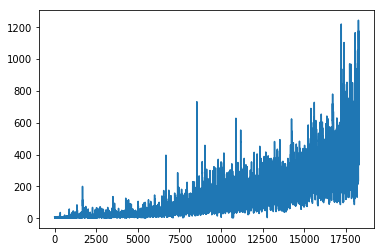

In [130]:
train['Count'].plot()
plt.show()

In [131]:
#calculate average hourly fraction to reduce noise from the data
hourly_frac = train.groupby(['hour']).mean()/np.sum(train.groupby(['hour']).mean())

In [132]:
#drop index col and replace with col name to 'fraction'
hourly_frac.drop(['ID'], axis = 1, inplace = True)
hourly_frac.columns = ['fraction']

In [133]:
#convert to time series from dataframe
train.index = train.Datetime #setting index
train.drop(['ID','hour','Datetime'], axis = 1, inplace = True)

In [134]:
#group_by day
daily_train = train.resample('D').sum()

In [135]:
#help your unstanding
daily_train.head()

,Count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [136]:
'''Prophet requires the variable names in the time series to be:

y – Target
ds – Datetime
So, the next step is to convert the dataframe according to the above specifications'''

'Prophet requires the variable names in the time series to be:\n\ny – Target\nds – Datetime\nSo, the next step is to convert the dataframe according to the above specifications'

In [137]:
daily_train['ds']= daily_train.index
daily_train['y'] = daily_train.Count
#drop Count col since we have y col
daily_train.drop(['Count'], axis =1, inplace = True)

In [138]:
#quick look at the df before we fit the model
daily_train.tail() #looks gud

,ds,y
Datetime,,
2014-09-21,2014-09-21,9102
2014-09-22,2014-09-22,14116
2014-09-23,2014-09-23,13304
2014-09-24,2014-09-24,16856
2014-09-25,2014-09-25,14152


In [139]:
#Fitting the FB Prophet model
m = Prophet(yearly_seasonality = True, seasonality_prior_scale = 0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods = 213)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\vinhn\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


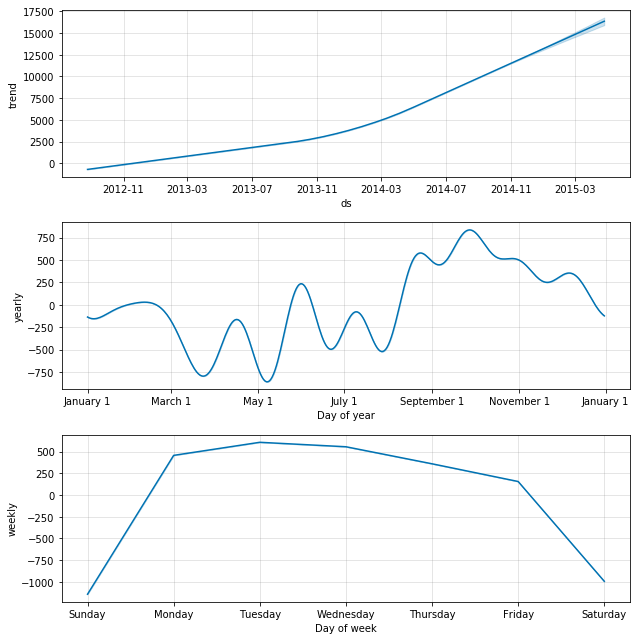

In [140]:
m.plot_components(forecast)

In [143]:
# Extract hour, day, month and year from both dataframes to merge
for df in [test]:
    df['hour'] = df.Datetime.dt.hour
    df['day'] = df.Datetime.dt.day
    df['month'] = df.Datetime.dt.month
    df['year'] = df.Datetime.dt.year

In [144]:
for df in [forecast]:
    df['hour'] = df.ds.dt.hour
    df['day'] = df.ds.dt.day
    df['month'] = df.ds.dt.month
    df['year'] = df.ds.dt.year

In [148]:
forecast.drop('hour', axis = 1, inplace= True)

In [149]:
# Merge forecasts with given IDs
test = pd.merge(test,forecast, on=['day','month','year'], how='left')
cols = ['ID','hour','yhat']
test_new = test[cols]

In [155]:
test.head()

,ID,Datetime,hour,day,month,year,ds,trend,yhat_lower,yhat_upper,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,18288,2014-09-26 00:00:00,0,26,9,2014,2014-09-26,10520.686919,10266.563343,12698.597554,...,155.993137,155.993137,155.993137,832.132392,832.132392,832.132392,0.0,0.0,0.0,11508.812447
1,18289,2014-09-26 01:00:00,1,26,9,2014,2014-09-26,10520.686919,10266.563343,12698.597554,...,155.993137,155.993137,155.993137,832.132392,832.132392,832.132392,0.0,0.0,0.0,11508.812447
2,18290,2014-09-26 02:00:00,2,26,9,2014,2014-09-26,10520.686919,10266.563343,12698.597554,...,155.993137,155.993137,155.993137,832.132392,832.132392,832.132392,0.0,0.0,0.0,11508.812447
3,18291,2014-09-26 03:00:00,3,26,9,2014,2014-09-26,10520.686919,10266.563343,12698.597554,...,155.993137,155.993137,155.993137,832.132392,832.132392,832.132392,0.0,0.0,0.0,11508.812447
4,18292,2014-09-26 04:00:00,4,26,9,2014,2014-09-26,10520.686919,10266.563343,12698.597554,...,155.993137,155.993137,155.993137,832.132392,832.132392,832.132392,0.0,0.0,0.0,11508.812447


In [151]:



# Merging hourly average fraction to the test data
test_new = pd.merge(test_new, hourly_frac, left_on = ['hour'], right_index=True, how = 'left')
# Convert daily aggregate to hourly traffic
test_new['Count'] = test_new['yhat'] * test_new['fraction']
test_new.drop(['yhat','fraction','hour'],axis = 1, inplace = True)
test_new.to_csv('prophet_sub.csv',index = False)


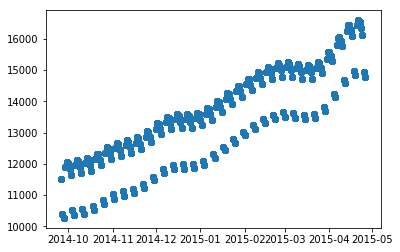

In [159]:
#plot upper yhat, yhat and lower yhat with test dates.
plt.plot_date(test['ds'],test['yhat'])
plt.show()